## Initial setup

Validate your python environment here.

In [153]:
import gzip
import os
import urllib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rdkit
import rdkit.Chem
import rdkit.Chem.Draw
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit import Chem, DataStructs
from scipy.stats import randint, uniform
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline


Specify some configurations for the notebook.

In [27]:
DOWNLOAD_DIR = "datasets"

SOURCES = {
    "clintox": {
        "download_url": "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/clintox.csv.gz",
        "file_name": "clintox.csv",
    },
    "toxcast": {
        "download_url": "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/toxcast_data.csv.gz",
        "file_name": "toxcast.csv",
    },
    "pcba": {
        "download_url": "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/pcba.csv.gz",
        "file_name": "pcba.csv",
    },
}

Now we'll define some data loading helpers:
- `fetch_data` downloads a local copy of the files specified in `SOURCES` above.
- `load_data(name)` returns a dataframe that was extracted from the downloaded file.

Example usages can be seen below.

In [28]:
# We'll maintain a global cache of dataframes to avoid re-loading them
global DATA_CACHE
DATA_CACHE = {}


def fetch_data(source, force_redownload=False):
    # create storage path if it does not exist
    storage_path = os.path.join(DOWNLOAD_DIR, source)
    if not os.path.isdir(storage_path):
        os.makedirs(storage_path)

    # download file if it does not exist or if we want a fresh copy
    gz_file_path = os.path.join(storage_path, f"{SOURCES[source]['file_name']}.gz") 
    if not os.path.isfile(gz_file_path) or force_redownload:
        urllib.request.urlretrieve(SOURCES[source]["download_url"], gz_file_path)


def load_data(name):
    file_path = os.path.join(DOWNLOAD_DIR, name, SOURCES[name]["file_name"])

    #check if we've already loaded this data
    global DATA_CACHE
    if name in DATA_CACHE:
        return DATA_CACHE[name]

    # extract csv if we haven't already
    gz_file_path = f"{file_path}.gz"
    if not os.path.isfile(file_path):
        with gzip.open(gz_file_path, "rb") as f_in:
            with open(file_path, "wb") as f_out:
                f_out.write(f_in.read())

    data = pd.read_csv(file_path)

    # apply any initial cleaning through queries
    if name == "clintox":
        # # query for rows
        # data = data.query('''
        #     NOTE query goes here
        # ''').reset_index()
        pass
    elif name == "toxcast":
        # # query for rows
        # data = data.query('''
        #     NOTE query goes here
        # ''').reset_index()
        pass

    DATA_CACHE[name] = data
    return data


In [10]:
for source in SOURCES:
    fetch_data(source, force_redownload=False)

## Exploration

Starting with some basic inspection

In [16]:
load_data("clintox").head()

,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0


In [17]:
load_data("clintox").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   smiles        1484 non-null   object
 1   FDA_APPROVED  1484 non-null   int64 
 2   CT_TOX        1484 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 34.9+ KB


In [18]:
load_data("toxcast").head()

,smiles,ACEA_T47D_80hr_Negative,ACEA_T47D_80hr_Positive,APR_HepG2_CellCycleArrest_24h_dn,APR_HepG2_CellCycleArrest_24h_up,APR_HepG2_CellCycleArrest_72h_dn,APR_HepG2_CellLoss_24h_dn,APR_HepG2_CellLoss_72h_dn,APR_HepG2_MicrotubuleCSK_24h_dn,APR_HepG2_MicrotubuleCSK_24h_up,...,Tanguay_ZF_120hpf_OTIC_up,Tanguay_ZF_120hpf_PE_up,Tanguay_ZF_120hpf_PFIN_up,Tanguay_ZF_120hpf_PIG_up,Tanguay_ZF_120hpf_SNOU_up,Tanguay_ZF_120hpf_SOMI_up,Tanguay_ZF_120hpf_SWIM_up,Tanguay_ZF_120hpf_TRUN_up,Tanguay_ZF_120hpf_TR_up,Tanguay_ZF_120hpf_YSE_up
0,[O-][N+](=O)C1=CC=C(Cl)C=C1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CN1CCN(CC1)C(=O)C1CCCCC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NC1=CC=C(C=C1)[N+]([O-])=O,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,OC1=CC=C(C=C1)[N+]([O-])=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
load_data("toxcast").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8597 entries, 0 to 8596
Columns: 618 entries, smiles to Tanguay_ZF_120hpf_YSE_up
dtypes: float64(617), object(1)
memory usage: 40.5+ MB


In [20]:
load_data("pcba").head()

,PCBA-1030,PCBA-1379,PCBA-1452,PCBA-1454,PCBA-1457,PCBA-1458,PCBA-1460,PCBA-1461,PCBA-1468,PCBA-1469,...,PCBA-914,PCBA-915,PCBA-924,PCBA-925,PCBA-926,PCBA-927,PCBA-938,PCBA-995,mol_id,smiles
0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CID1511280,CC(=O)N1CCC2(CC1)NC(=O)N(c1ccccc1)N2
1,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CID332939,N#Cc1nnn(-c2ccc(Cl)cc2)c1N
2,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CID3800322,COC(=O)c1ccc(NC(=O)c2ccccc2CC[N+](=O)[O-])cc1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CID46904422,CCC1NC(=O)c2cccnc2-n2c1nc1ccc(F)cc1c2=O
4,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CID16445987,CC1=CC(=O)/C(=C2/C=C(C(=O)Nc3ccc(S(=O)(=O)Nc4o...


In [12]:
load_data("pcba").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437929 entries, 0 to 437928
Columns: 130 entries, PCBA-1030 to smiles
dtypes: float64(128), object(2)
memory usage: 434.3+ MB


It could help to get a better understanding of the SMILES format by comparing it to the actual molecule. Running this cell will give you a comparison for a random molecule in the toxcast dataset.

B([C@H](CC(C)C)NC(=O)[C@H](Cc1ccccc1)NC(=O)c2cnccn2)(O)O


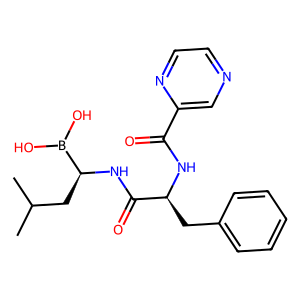

In [21]:
def random_molecule():
    clintox_data = load_data("clintox")
    return clintox_data["smiles"][np.random.randint(len(clintox_data))]

def display_molecule(molecule):
    print(molecule)
    return rdkit.Chem.Draw.MolToImage(rdkit.Chem.MolFromSmiles(molecule))

display_molecule(random_molecule())

<b>Data Exploration</b>

In [48]:
## Load Data ##
df_c = load_data("clintox")
df_t = load_data("toxcast")

In [49]:
df_t.describe()

,ACEA_T47D_80hr_Negative,ACEA_T47D_80hr_Positive,APR_HepG2_CellCycleArrest_24h_dn,APR_HepG2_CellCycleArrest_24h_up,APR_HepG2_CellCycleArrest_72h_dn,APR_HepG2_CellLoss_24h_dn,APR_HepG2_CellLoss_72h_dn,APR_HepG2_MicrotubuleCSK_24h_dn,APR_HepG2_MicrotubuleCSK_24h_up,APR_HepG2_MicrotubuleCSK_72h_dn,...,Tanguay_ZF_120hpf_OTIC_up,Tanguay_ZF_120hpf_PE_up,Tanguay_ZF_120hpf_PFIN_up,Tanguay_ZF_120hpf_PIG_up,Tanguay_ZF_120hpf_SNOU_up,Tanguay_ZF_120hpf_SOMI_up,Tanguay_ZF_120hpf_SWIM_up,Tanguay_ZF_120hpf_TRUN_up,Tanguay_ZF_120hpf_TR_up,Tanguay_ZF_120hpf_YSE_up
count,1740.000000,1740.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1024.00000,...,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000
mean,0.256897,0.171839,0.168431,0.042348,0.235804,0.289702,0.431184,0.059673,0.087584,0.06250,...,0.042885,0.119883,0.055556,0.045809,0.109162,0.039961,0.034113,0.058480,0.081871,0.127680
std,0.437047,0.377349,0.374429,0.201480,0.424704,0.453842,0.495480,0.236994,0.282825,0.24218,...,0.202697,0.324983,0.229173,0.209173,0.311994,0.195963,0.181608,0.234762,0.274302,0.333896
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [50]:
## Compute NULL Percentage ##
def remove_null_columns(df, null_threshold_pct = 0.5):
    """
    Remove columns with specified frequency of null values.
    """
    row_count = df.shape[0]
    
    # Compute % of Null Entries
    df_nulls = df.isna().sum()/row_count
    
    # Filter based on Threshold
    df_filtered = df_nulls[df_nulls < null_threshold_pct]
    
    # Filter Columns from DataFrame
    columns = df_filtered.index
    df = df[columns]
    
    return df

# Create Count of Missing Features Column
df_t['feature_sum'] = df_t.sum(axis = 1, numeric_only = True)

# Create Count of Missing Features Column
df_t['missing_features'] = df_t.isna().sum(axis = 1)

# Every row has at least one missing feature
df_t[df_t['missing_features'] == 0]

df_t

,smiles,ACEA_T47D_80hr_Negative,ACEA_T47D_80hr_Positive,APR_HepG2_CellCycleArrest_24h_dn,APR_HepG2_CellCycleArrest_24h_up,APR_HepG2_CellCycleArrest_72h_dn,APR_HepG2_CellLoss_24h_dn,APR_HepG2_CellLoss_72h_dn,APR_HepG2_MicrotubuleCSK_24h_dn,APR_HepG2_MicrotubuleCSK_24h_up,...,Tanguay_ZF_120hpf_PFIN_up,Tanguay_ZF_120hpf_PIG_up,Tanguay_ZF_120hpf_SNOU_up,Tanguay_ZF_120hpf_SOMI_up,Tanguay_ZF_120hpf_SWIM_up,Tanguay_ZF_120hpf_TRUN_up,Tanguay_ZF_120hpf_TR_up,Tanguay_ZF_120hpf_YSE_up,feature_sum,missing_features
0,[O-][N+](=O)C1=CC=C(Cl)C=C1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,204
1,C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,517
2,CN1CCN(CC1)C(=O)C1CCCCC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,521
3,NC1=CC=C(C=C1)[N+]([O-])=O,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,183
4,OC1=CC=C(C=C1)[N+]([O-])=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8592,[O-]S(=O)(=O)C(F)(F)F.CCCC[N+]1=CC=CC=C1C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,517
8593,F[P-](F)(F)(F)(F)F.CCCC[N+]1=CC=CC=C1C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,517
8594,[O-]S(=O)(=O)C(F)(F)F.CCC[N+]1(C)CCCC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,517
8595,CCCCCCCCCCCCC1=CC=CC=C1S([O-])(=O)=O.CCCCCCCCC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,517


In [51]:
# 2393 / 8596 Rows have NaN or 0 in their features.
df_t[df_t['feature_sum'] == 0]

,smiles,ACEA_T47D_80hr_Negative,ACEA_T47D_80hr_Positive,APR_HepG2_CellCycleArrest_24h_dn,APR_HepG2_CellCycleArrest_24h_up,APR_HepG2_CellCycleArrest_72h_dn,APR_HepG2_CellLoss_24h_dn,APR_HepG2_CellLoss_72h_dn,APR_HepG2_MicrotubuleCSK_24h_dn,APR_HepG2_MicrotubuleCSK_24h_up,...,Tanguay_ZF_120hpf_PFIN_up,Tanguay_ZF_120hpf_PIG_up,Tanguay_ZF_120hpf_SNOU_up,Tanguay_ZF_120hpf_SOMI_up,Tanguay_ZF_120hpf_SWIM_up,Tanguay_ZF_120hpf_TRUN_up,Tanguay_ZF_120hpf_TR_up,Tanguay_ZF_120hpf_YSE_up,feature_sum,missing_features
1,C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,517
5,CC1=CC(=O)NO1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,514
17,CCCCCCCC(OC)OC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,471
18,[Ba++].[O-][N+]([O-])=O.[O-][N+]([O-])=O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,517
28,CCCCCCCCCCCl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8590,F[P-](F)(F)(F)(F)F.CCC[N+]1(C)CCCCC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,517
8591,CCCCCCCCCCCCCCC(CO)\N=C(\O)CCCCCCCCCCCCCC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,517
8592,[O-]S(=O)(=O)C(F)(F)F.CCCC[N+]1=CC=CC=C1C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,517
8594,[O-]S(=O)(=O)C(F)(F)F.CCC[N+]1(C)CCCC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,517


There are multiple ways to convert a molecule from SMILES format into features that can be used by a model.

Option 1: Create Graph. This forces us to use something that takes graphs as inputs (e.g. graph neural networks)

In [13]:
ELEMENTS = {
    0: "X",
    1: "H",
    6: "C",
    7: "N",
    8: "O",
    9: "F",
    14: "Si",
    15: "P",
    16: "S",
    17: "Cl",
    80: "Hg",
}

def convert_to_graph(sml):
    """Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    
    N = len(list(m.GetAtoms()))
    
    nodes = np.zeros((N, len(ELEMENTS)))
    lookup = list(ELEMENTS.keys())
    for i in m.GetAtoms():
        nodes[i.GetIdx(), lookup.index(i.GetAtomicNum())] = 1

    adj = np.zeros((N, N, 5))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v, order] = 1
        adj[v, u, order] = 1
    return nodes, adj


Option 2: Convert to single array.

In [55]:
def convert_to_bits(smile, bits=256):
    mol = Chem.rdmolfiles.MolFromSmiles(smile)
    
    fingerprint = rdMolDescriptors.GetMorganFingerprintAsBitVect(
        mol, radius=2, bitInfo={}, nBits=bits, useChirality=True,
    )
    
    arr = np.zeros((1,), dtype=int)
    DataStructs.ConvertToNumpyArray(fingerprint, arr)

    return arr

Let's see what these features look like...

Cc1c2c(cc(c1F)N3CC[NH2+]C(C3)C)n(cc(c2=O)C(=O)[O-])C4CC4


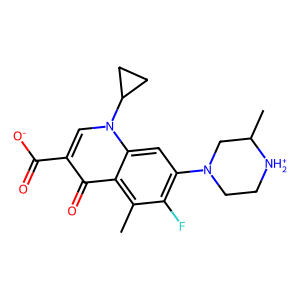

In [24]:
molecule = random_molecule()
display_molecule(molecule)

Note: if you get an error about a number not being in a list, that probably means that atomic number is missing from `ELEMENTS` above

In [30]:
convert_to_graph(molecule)

(array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.,

In [38]:
convert_to_bits(molecule)

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0])

## Predicting Toxicity

In [156]:
def partition_data(data, n_splits, split_size):
    remaining_size, splits = 1.0, []
    
    for _ in range(n_splits):
        remaining, split = train_test_split(
            data,
            test_size=split_size/remaining_size,
            random_state=123,
        )
        splits.append(split)

        remaining_size -= split_size
        data = remaining

    return [remaining, *splits]


def get_features_and_labels(data, label_column_name="toxic"):
    return dict(
        features=data.drop(label_column_name, axis=1).copy(),
        labels=data[label_column_name].copy(),
    )


def analyze_hyperparameters(X, y, classifier, param_grid, figsize=(8, 8)):
    scoring_methods = [
        "accuracy", "precision", "recall", "balanced_accuracy", "f1",
    ]

    fig, axs = plt.subplots(
        nrows=len(scoring_methods),
        ncols=len(param_grid),
        figsize=figsize,
    )
    axs = axs.ravel()

    for i, scoring_method in enumerate(scoring_methods):
        print(f"Scoring: {scoring_method+'...':<21}", end="")
        for j, param_name in enumerate(param_grid):
            grid = GridSearchCV(
                classifier,
                param_grid={param_name: param_grid[param_name]},
                scoring=scoring_method,
                n_jobs=-1,
            )
            grid.fit(X, y)

            axs[len(param_grid)*i + j].plot(
                param_grid[param_name],
                grid.cv_results_['mean_test_score'],
                color=['red', 'darkgoldenrod', 'blue', 'purple', 'green'][i]
            )
            if (i == 0):
                axs[len(param_grid)*i + j].set_title(param_name)
            if (j == 0):
                axs[len(param_grid)*i + j].set_ylabel(scoring_method)

        print(f"Done {i+1}/{len(scoring_methods)}.")

    plt.tight_layout()
    plt.show()


def search_and_validate(X, y, X_val, y_val, classifier, param_grid, n_iter=20, scoring="f1"):
    grid = RandomizedSearchCV(
        classifier,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring=scoring,
        n_jobs=-1,
        random_state=123,
    )
    grid.fit(X, y)

    y_pred = grid.best_estimator_.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y, y_pred, average='binary',
    )

    y_pred_val = grid.best_estimator_.predict(X_val)
    accuracy_val = accuracy_score(y_val, y_pred_val)
    precision_val, recall_val, f1_val, _ = precision_recall_fscore_support(
        y_val, y_pred_val, average='binary',
    )

    print(f"Best parameters: {grid.best_params_}")
    print(f"Training score: {f1}")
    print(f"  Accuracy: {accuracy}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"Validation score: {f1_val}")
    print(f"  Accuracy: {accuracy_val}")
    print(f"  Precision: {precision_val}")
    print(f"  Recall: {recall_val}")

    return grid


In [35]:
clintox_data = load_data("clintox")
clintox_data.head()

,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0


In [129]:
class _Base(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X


class ColumnCleaner(_Base):
    def transform(self, X, y=None):
        _X = X.copy()

        _X["toxic"] = _X["CT_TOX"]
        _X = _X.drop(columns=["CT_TOX", "FDA_APPROVED"])

        return _X


class DropInvalidSmiles(_Base):
    def transform(self, X, y=None):
        _X = X.copy()

        _X["molecule"] = _X["smiles"].apply(rdkit.Chem.MolFromSmiles)
        _X = _X[~_X["molecule"].isna()]
        _X = _X.drop(columns=["molecule"])

        return _X
    

class SmilesToBits(_Base):
    def transform(self, X, y=None):
        _X = pd.DataFrame(
            X["smiles"].apply(convert_to_bits).tolist(),
            columns=[f"fingerprint_{i}" for i in range(256)],
        )
        _X["toxic"] = X["toxic"]

        return _X
    

class ToxicInt(_Base):
    def transform(self, X, y=None):
        _X = X.copy()

        _X["toxic"] = _X["toxic"].apply(lambda x: 1 if x == 1 else 0)

        return _X

In [130]:
pipeline = Pipeline(
    [
        ("clean_columns", ColumnCleaner()),
        ("drop_invalid", DropInvalidSmiles()),
        ("smiles_to_bits", SmilesToBits()),
        ("toxic_as_int", ToxicInt()),
    ]
)

prepped_data = pipeline.fit_transform(clintox_data)

[22:37:27] Explicit valence for atom # 0 N, 5, is greater than permitted
[22:37:27] Can't kekulize mol.  Unkekulized atoms: 9
[22:37:27] Explicit valence for atom # 10 N, 4, is greater than permitted
[22:37:27] Explicit valence for atom # 10 N, 4, is greater than permitted
[22:37:27] Can't kekulize mol.  Unkekulized atoms: 4
[22:37:27] Can't kekulize mol.  Unkekulized atoms: 4


In [131]:
prepped_data.head()

,fingerprint_0,fingerprint_1,fingerprint_2,fingerprint_3,fingerprint_4,fingerprint_5,fingerprint_6,fingerprint_7,fingerprint_8,fingerprint_9,...,fingerprint_247,fingerprint_248,fingerprint_249,fingerprint_250,fingerprint_251,fingerprint_252,fingerprint_253,fingerprint_254,fingerprint_255,toxic
0,1,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [152]:
print(len(prepped_data))
print(prepped_data["toxic"].value_counts(normalize=True))
print(clintox_data["CT_TOX"].value_counts(normalize=True))


1478
0    0.924222
1    0.075778
Name: toxic, dtype: float64
0    0.924528
1    0.075472
Name: CT_TOX, dtype: float64


In [133]:
train_data, val_data, test_data = partition_data(prepped_data, 2, 0.15)

print(train_data["toxic"].value_counts(normalize=True))
print(val_data["toxic"].value_counts(normalize=True))
print(test_data["toxic"].value_counts(normalize=True))

0    0.925532
1    0.074468
Name: toxic, dtype: float64
0    0.923423
1    0.076577
Name: toxic, dtype: float64
0    0.918919
1    0.081081
Name: toxic, dtype: float64


In [134]:
X_train, y_train = get_features_and_labels(train_data).values()
X_val, y_val = get_features_and_labels(val_data).values()
X_test, y_test = get_features_and_labels(test_data).values()

Scoring: accuracy...          Done 1/5.
Scoring: precision...         Done 2/5.
Scoring: recall...            Done 3/5.
Scoring: balanced_accuracy... Done 4/5.
Scoring: f1...                Done 5/5.


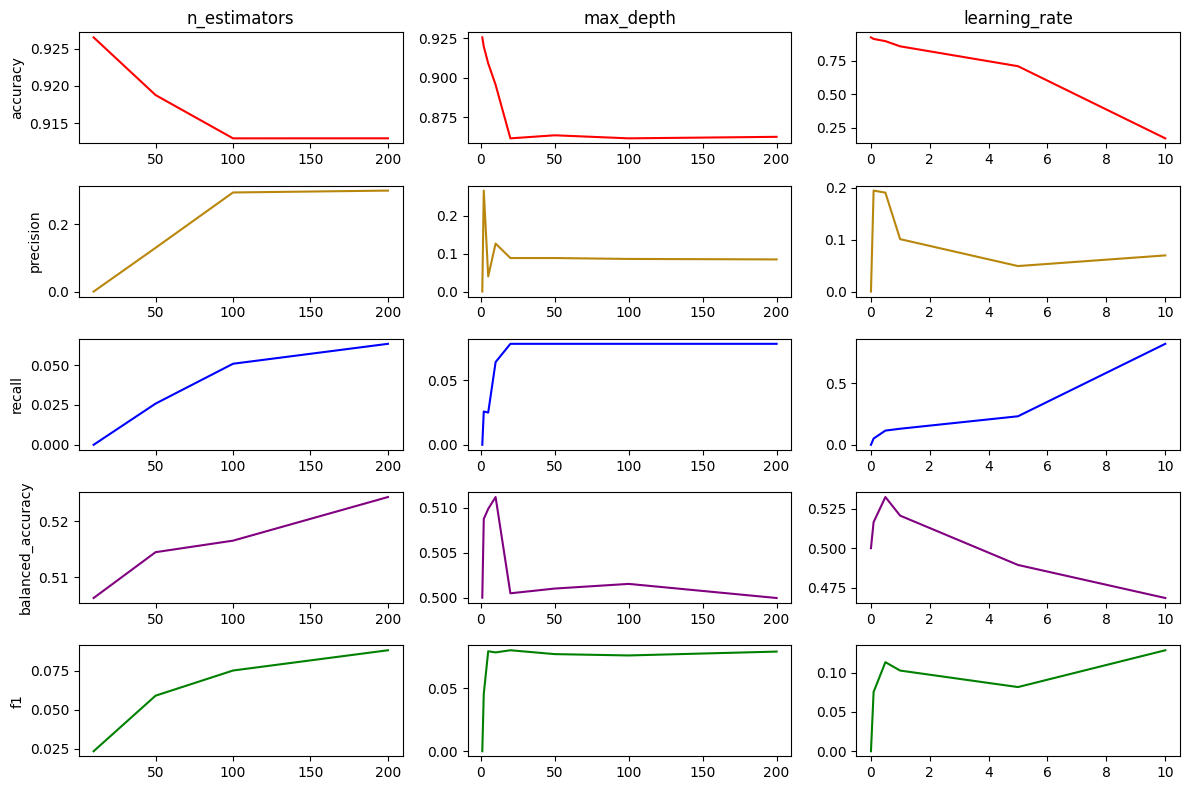

In [147]:
analyze_hyperparameters(
    X_train, y_train,
    classifier=GradientBoostingClassifier(),
    param_grid={
        "n_estimators": [10, 50, 100, 200],
        "max_depth": [1, 2, 5, 10, 20, 50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
    },
    figsize=(12, 8),
)

In [157]:
grid = search_and_validate(
    X_train, y_train,
    X_val, y_val,
    classifier=GradientBoostingClassifier(),
    param_grid={
        "n_estimators": randint(200, 500),
        "max_depth": randint(1, 25),
        "learning_rate": uniform(0.01, 50),
    },
    n_iter=20,
)

Best parameters: {'learning_rate': 21.3015145147914, 'max_depth': 5, 'n_estimators': 471}
Training score: 0.16445623342175067
  Accuracy: 0.390715667311412
  Precision: 0.0915805022156573
  Recall: 0.8051948051948052
Validation score: 0.08588957055214724
  Accuracy: 0.32882882882882886
  Precision: 0.04794520547945205
  Recall: 0.4117647058823529
